In [1]:
# Grundlegende Libraries importieren
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
df_observation_andermatt = pd.read_csv('../data/wasserstand/camels_ch/timeseries/observation_based/CAMELS_CH_obs_based_2087.csv')

# 'date'-Spalte in datetime-Format umwandeln
df_observation_andermatt['date'] = pd.to_datetime(df_observation_andermatt['date'])

# Als Index setzen
df_observation_andermatt.set_index('date', inplace=True)


df_observation_andermatt

,discharge_vol(m3/s),discharge_spec(mm/d),waterlevel(m),precipitation(mm/d),temperature_min(degC),temperature_mean(degC),temperature_max(degC),rel_sun_dur(%),swe(mm)
date,,,,,,,,,
1981-01-01,1.960,0.890,1426.559,7.96,-13.14,-7.66,-1.06,5.17,NaN
1981-01-02,1.763,0.801,1426.546,11.66,-13.26,-10.12,-3.96,0.44,NaN
1981-01-03,1.827,0.830,1426.550,33.11,-8.13,-3.90,-0.99,25.89,NaN
1981-01-04,1.837,0.835,1426.550,40.16,-13.63,-7.57,-4.23,0.05,NaN
1981-01-05,1.771,0.805,1426.546,12.72,-15.26,-14.08,-13.03,0.04,NaN
...,...,...,...,...,...,...,...,...,...
2020-12-27,2.546,1.157,1426.579,0.85,-12.28,-7.29,-3.80,0.04,218.0
2020-12-28,2.712,1.232,1426.589,0.67,-11.63,-8.97,-7.13,1.82,220.0
2020-12-29,2.616,1.188,1426.583,0.30,-10.72,-8.95,-7.50,0.18,221.0


In [3]:
df_important_coef = df_observation_andermatt[['waterlevel(m)','discharge_vol(m3/s)','temperature_mean(degC)', 'precipitation(mm/d)']]
df_important_coef

,waterlevel(m),discharge_vol(m3/s),temperature_mean(degC),precipitation(mm/d)
date,,,,
1981-01-01,1426.559,1.960,-7.66,7.96
1981-01-02,1426.546,1.763,-10.12,11.66
1981-01-03,1426.550,1.827,-3.90,33.11
1981-01-04,1426.550,1.837,-7.57,40.16
1981-01-05,1426.546,1.771,-14.08,12.72
...,...,...,...,...
2020-12-27,1426.579,2.546,-7.29,0.85
2020-12-28,1426.589,2.712,-8.97,0.67
2020-12-29,1426.583,2.616,-8.95,0.30


In [4]:
def plot_seasonal_decompose_all(df, period=365, model_type='additive'):
    """
    Fuehrt eine saisonale Dekomposition fuer alle numerischen Spalten eines DataFrames durch 
    und erstellt zu jeder Spalte ein Plot der Zerlegung in Trend, Saison und Restkomponente.
    Zudem fuhrt sie Augmented Dickey-Fuller Tests auf ganze Zeitreihe, Residuen und Trend durch
    und gibt die p-Werte aus.
    
    Parameter
    ----------
    df : pandas.DataFrame
        Eingabedaten mit Zeitreihen in den Spalten.
    period : int, optional
        Länge des saisonalen Zyklus (Standard: 365). 
        Beispiel: 12 fuer monatliche Daten ueber ein Jahr.
    model_type : {'additive', 'multiplicative'}, optional
        Typ des Modells fuer die saisonale Komponente (Standard: 'additive').
    
    Hinweise
    --------
    - Die Funktion ignoriert nicht-numerische Spalten automatisch.
    - Bei Fehlern in einer Spalte wird eine Fehlermeldung ausgegeben, 
      ohne die Verarbeitung der weiteren Spalten zu unterbrechen.
    """
    for col in df.select_dtypes(include="number").columns:
        try:
            series = df[col].dropna()
            result = seasonal_decompose(series, model=model_type, period=period)
            fig = result.plot()
            fig.suptitle(f'Seasonal Decompose: {col}', fontsize=16)
            fig.set_size_inches(12, 10)
            plt.tight_layout()
            plt.show()

            # ADF Tests
            r = adfuller(series, maxlag=12)
            print(f'p-Wert ganze Zeitreihe ({col}): {r[1]:.6f}')

            temp_resid = result.resid.dropna()
            r = adfuller(temp_resid, maxlag=12)
            print(f'p-Wert Residuen ({col}): {r[1]:.6f}')

            temp_trend = result.trend.dropna()
            r = adfuller(temp_trend, maxlag=12)
            print(f'p-Wert Trend ({col}): {r[1]:.6f}')

            print('--------------------------------------------------')

        except Exception as e:
            print(f"Fehler bei '{col}': {e}")


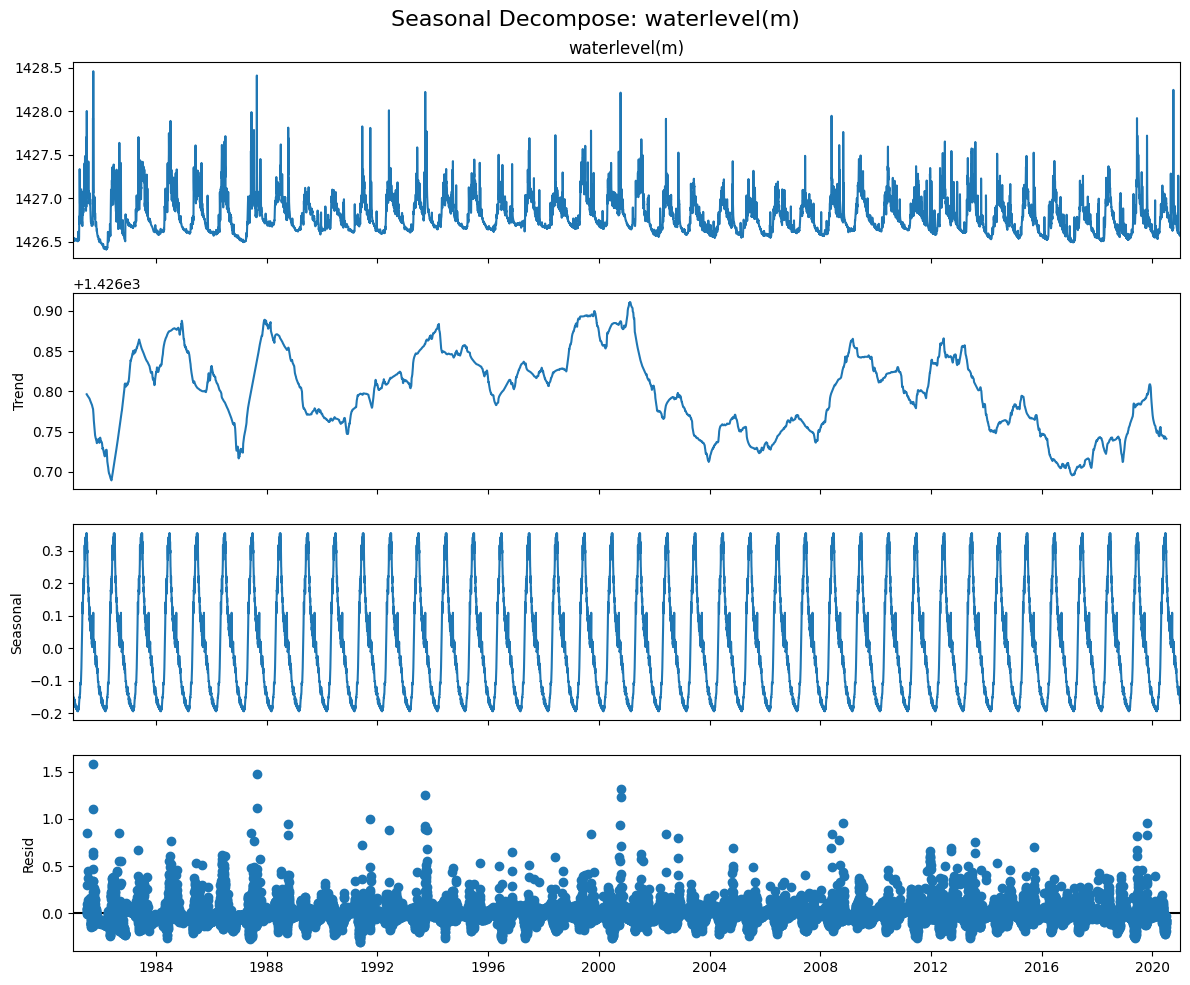

p-Wert ganze Zeitreihe (waterlevel(m)): 0.000000
p-Wert Residuen (waterlevel(m)): 0.000000
p-Wert Trend (waterlevel(m)): 0.126419
--------------------------------------------------


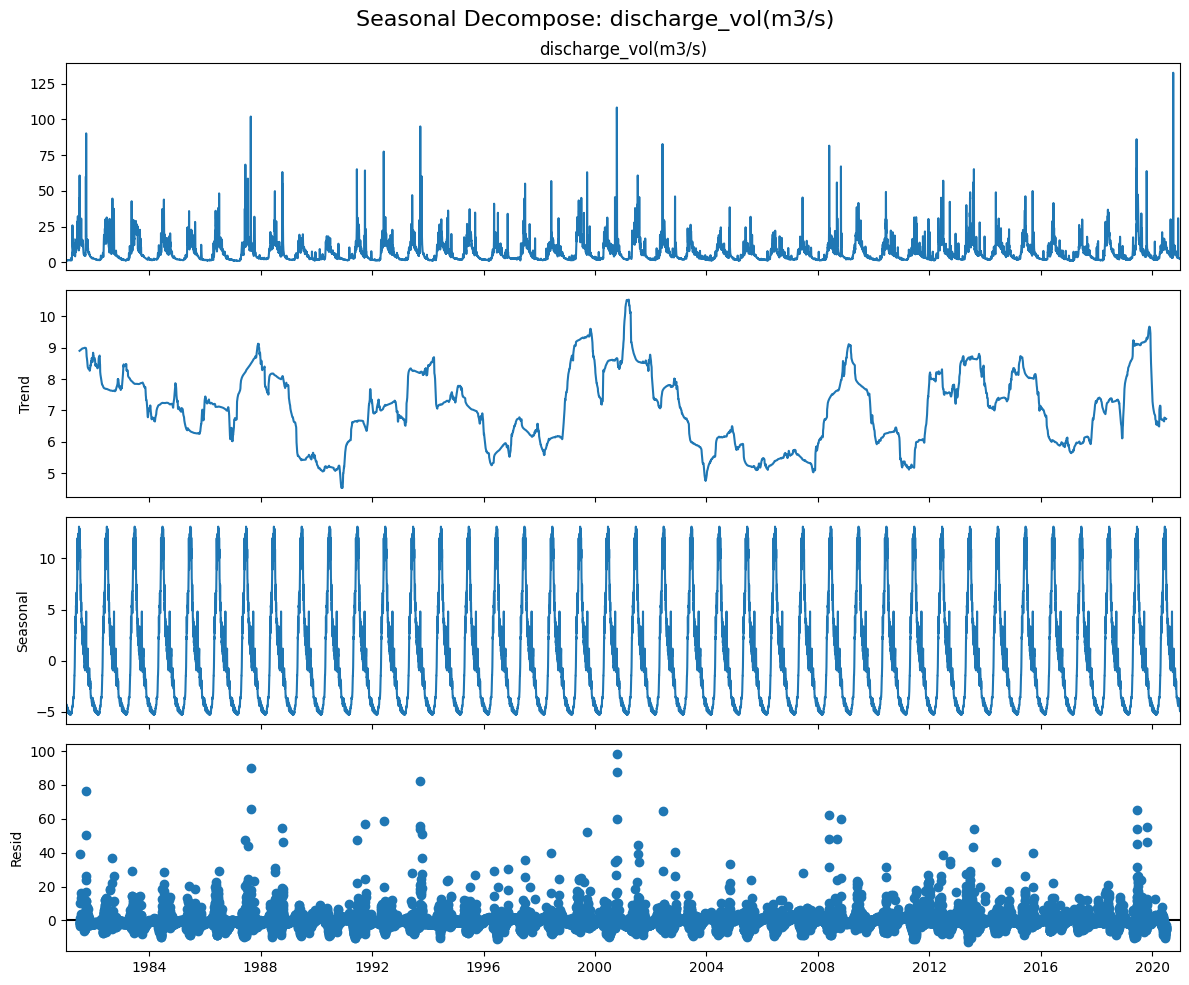

p-Wert ganze Zeitreihe (discharge_vol(m3/s)): 0.000000
p-Wert Residuen (discharge_vol(m3/s)): 0.000000
p-Wert Trend (discharge_vol(m3/s)): 0.004467
--------------------------------------------------


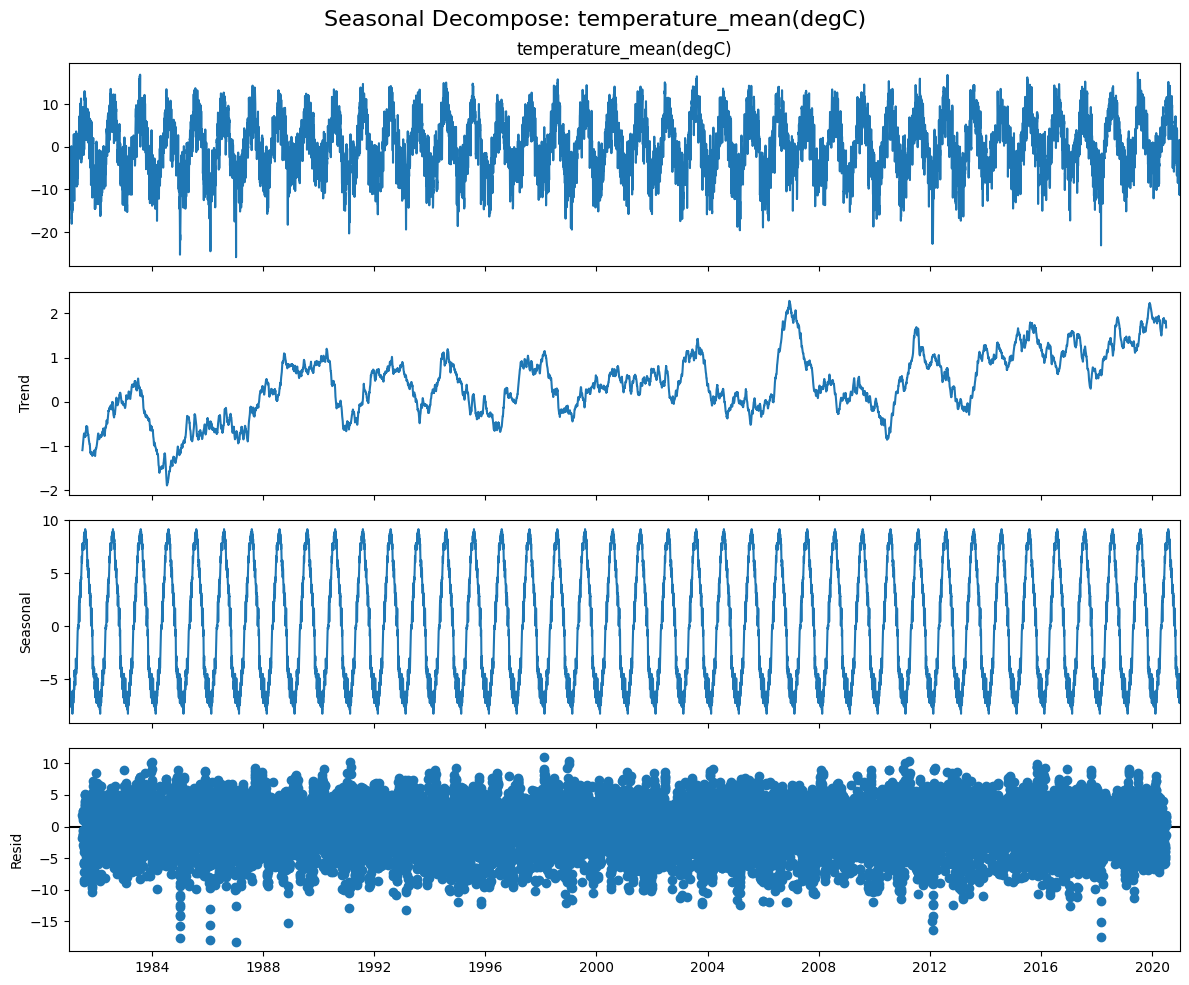

p-Wert ganze Zeitreihe (temperature_mean(degC)): 0.000000
p-Wert Residuen (temperature_mean(degC)): 0.000000
p-Wert Trend (temperature_mean(degC)): 0.009578
--------------------------------------------------


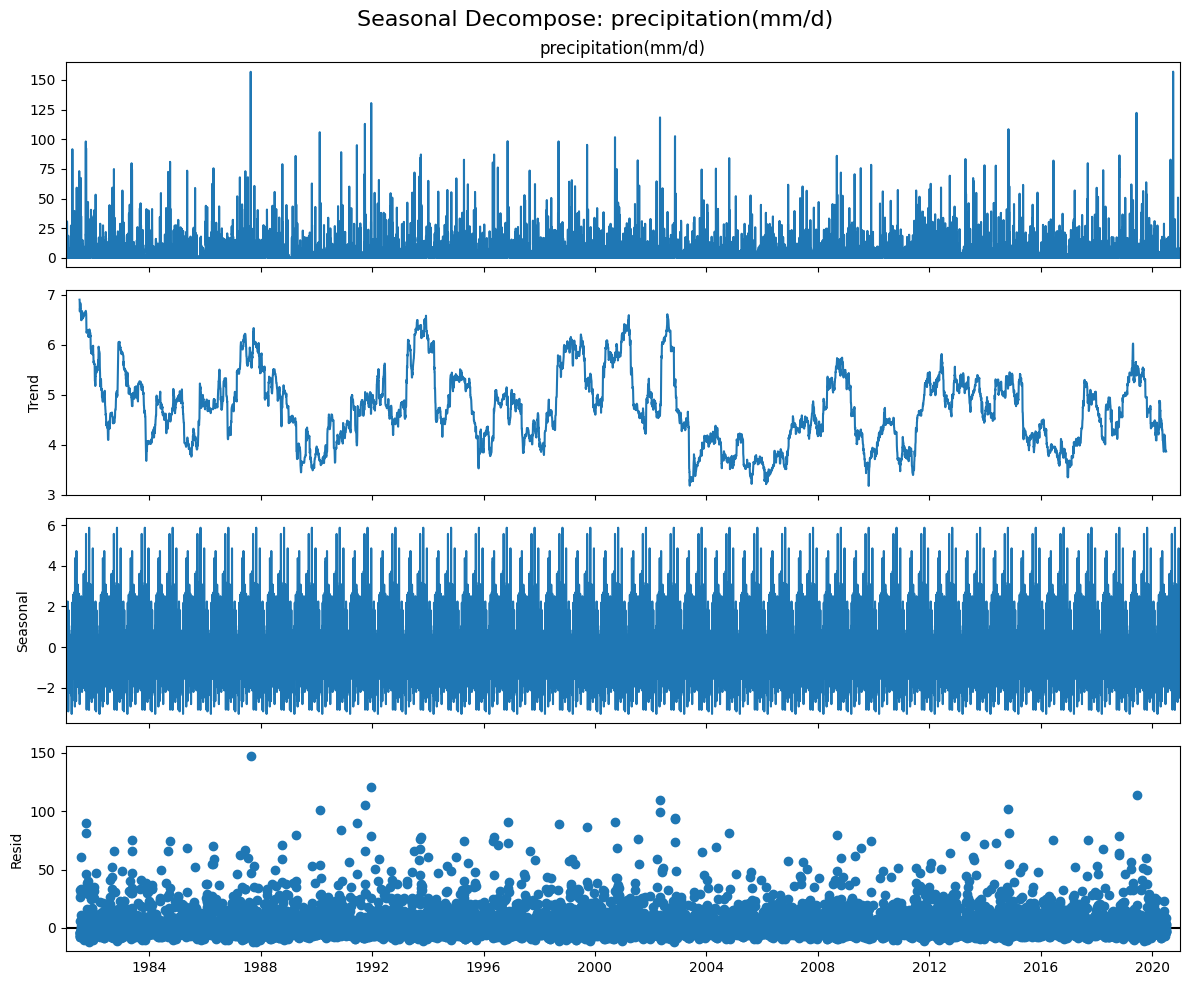

p-Wert ganze Zeitreihe (precipitation(mm/d)): 0.000000
p-Wert Residuen (precipitation(mm/d)): 0.000000
p-Wert Trend (precipitation(mm/d)): 0.000020
--------------------------------------------------


In [5]:
plot_seasonal_decompose_all(df_important_coef, period=365, model_type='additive')

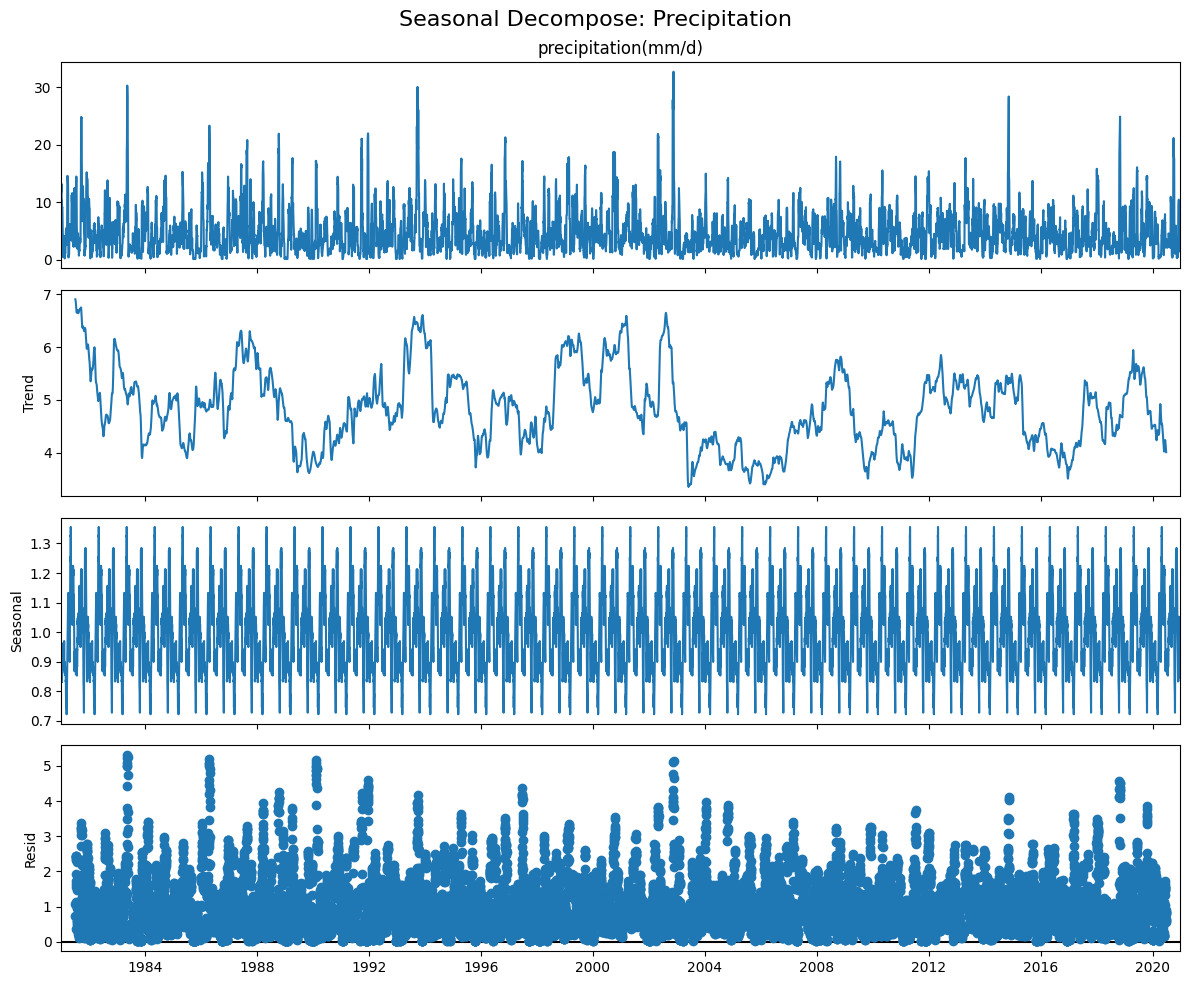

In [6]:
rain_data = df_important_coef['precipitation(mm/d)'].dropna()

rain_data_smooth = rain_data.rolling(window=14, center=True).mean().dropna()

rain_data_nonzero = rain_data_smooth + 0.1

rain_Decompose = seasonal_decompose(rain_data_nonzero, model='multiplicative', period=365)

# Plot der Zerlegung
fig = rain_Decompose.plot()
fig.suptitle('Seasonal Decompose: Precipitation', fontsize=16)
fig.set_size_inches(12, 10)
plt.tight_layout()
plt.show()

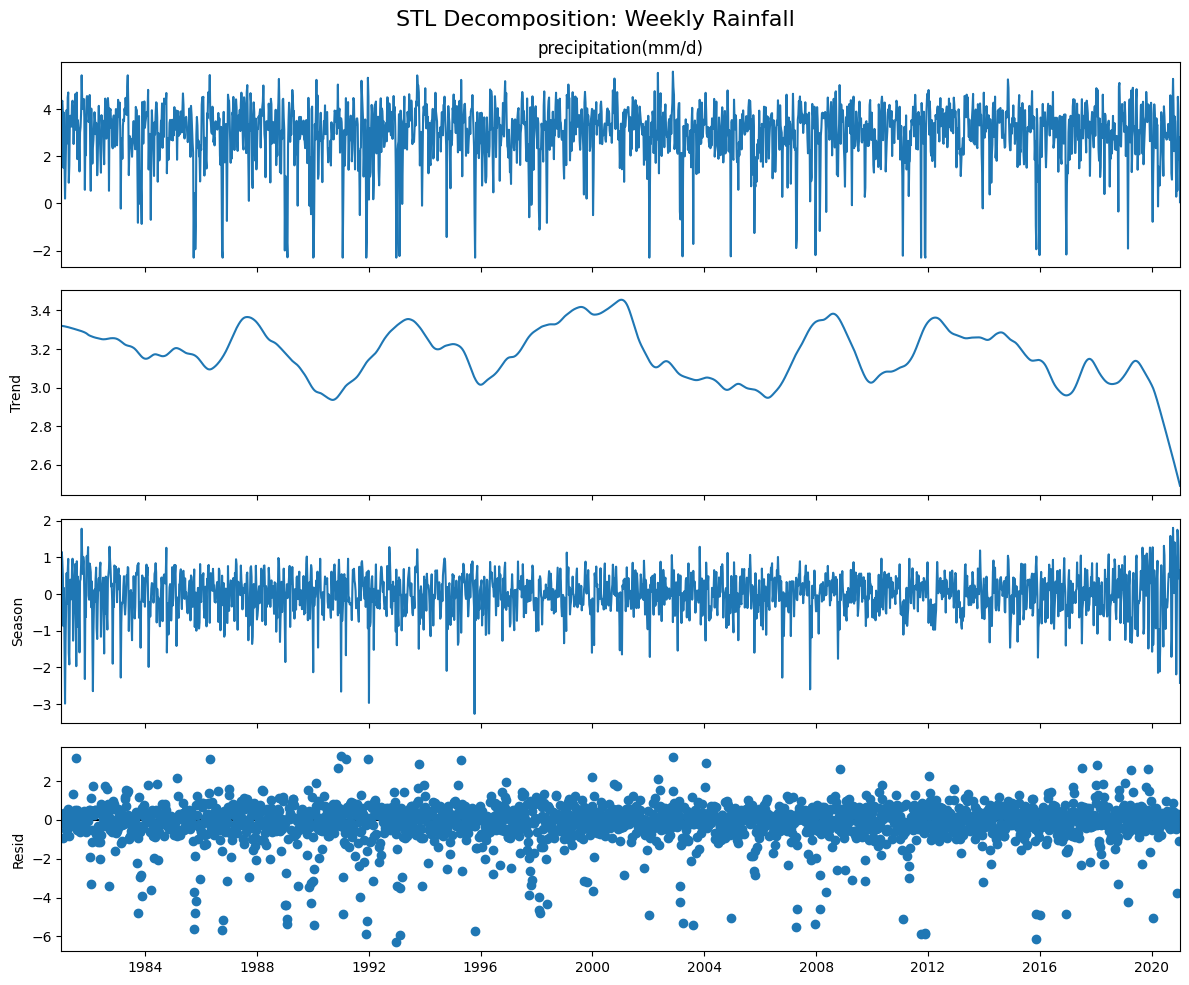

ADF Statistic: -29.35394810916184
p-value: 0.0
Residuen sind stationär


In [7]:
from statsmodels.tsa.seasonal import STL

# Niederschlagsdaten vorbereiten (tägliche Werte)
rain_data = df_important_coef['precipitation(mm/d)'].copy()
rain_data = rain_data.dropna()

# Optional: Glättung über 7 Tage (reduziert tägliche Sprünge)
rain_smooth = rain_data.rolling(window=7, center=True).mean().dropna()

# Optional: Aggregation auf Wochenbasis für stabilere saisonale Komponente
rain_weekly = rain_smooth.resample('W').sum()

# Optional: Log-Transformation zur Stabilisierung der Varianz (add small value to avoid log(0))
rain_transformed = np.log(rain_weekly + 0.1)

# STL-Dekomposition
stl = STL(rain_transformed, period=52, robust=True)
res = stl.fit()

# Plot der Komponenten
fig = res.plot()
fig.suptitle('STL Decomposition: Weekly Rainfall', fontsize=16)
fig.set_size_inches(12, 10)
plt.tight_layout()
plt.show()

# Trend- und saisonbereinigte Zeitreihe
deseasonalized = rain_transformed - res.seasonal
detrended = rain_transformed - res.trend

# Stationaritätstest (ADF-Test) der Residuen
adf_result = adfuller(res.resid.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("Residuen sind stationär")
else:
    print("Residuen sind nicht stationär ❌")

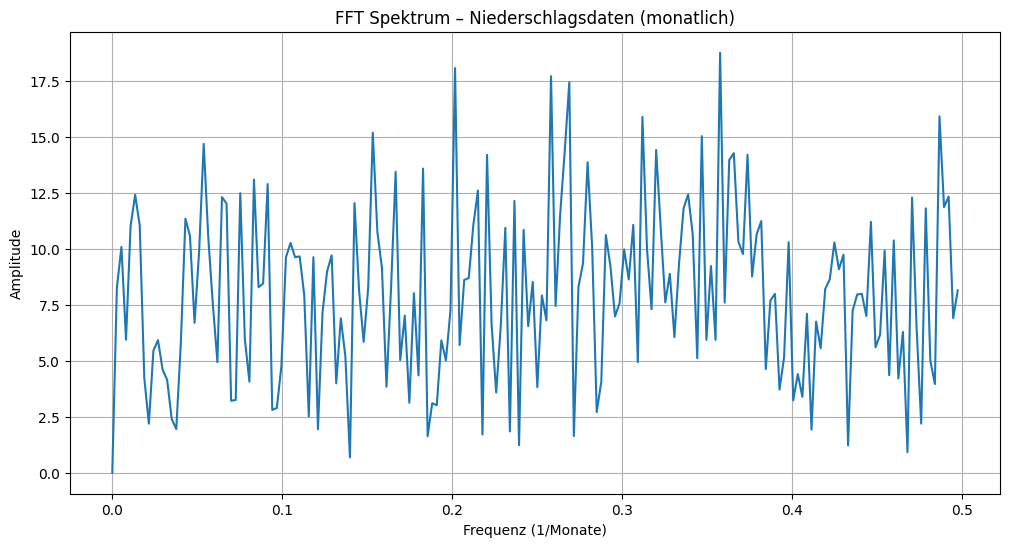


=== Dominante Perioden aus FFT ===
    Frequenz (1/Monat)  Periode (Monate)  Periode (Jahre)
16            0.486559          2.055249         0.171271
15            0.373656          2.676259         0.223022
14            0.365591          2.735294         0.227941
13            0.357527          2.796992         0.233083
12            0.346774          2.883721         0.240310
11            0.319892          3.126050         0.260504
10            0.311828          3.206897         0.267241
9             0.279570          3.576923         0.298077
8             0.268817          3.720000         0.310000
7             0.258065          3.875000         0.322917
6             0.220430          4.536585         0.378049
5             0.201613          4.960000         0.413333
4             0.182796          5.470588         0.455882
3             0.166667          6.000000         0.500000
2             0.153226          6.526316         0.543860
1             0.083333         12.00

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

rain_fft = rain_data
rain_fft = rain_data.resample("ME").sum()               # monatlich aggregieren
rain_fft = rain_fft["1985":"2015"] 

# Log-Transformation (optional aber empfohlen)


# Serie als 1D-Array
x = rain_fft.values.flatten()
N = len(x)
T = 1  # 1 Monat pro Sample

# --- 2) FFT berechnen ---
yf = fft(x - np.mean(x))     # Mittelwert entfernen → sauberere Peaks
xf = fftfreq(N, T)[:N//2]    # nur positive Frequenzen

amplitude = 2.0/N * np.abs(yf[0:N//2])

# --- 3) Plot: Frequenzspektrum ---
plt.figure(figsize=(12,6))
plt.plot(xf, amplitude)
plt.title("FFT Spektrum – Niederschlagsdaten (monatlich)")
plt.xlabel("Frequenz (1/Monate)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# --- 4) Dominante Perioden automatisch finden ---
from scipy.signal import find_peaks

# Nur signifikante Peaks
peaks, _ = find_peaks(amplitude, height=np.percentile(amplitude, 90))

dominant_freqs = xf[peaks]
dominant_periods = 1 / dominant_freqs

result = pd.DataFrame({
    "Frequenz (1/Monat)": dominant_freqs,
    "Periode (Monate)": dominant_periods,
    "Periode (Jahre)": dominant_periods/12
})

print("\n=== Dominante Perioden aus FFT ===")
print(result.sort_values("Periode (Monate)"))

C:\Users\adria\AppData\Local\Temp\ipykernel_24608\600510381.py:1: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / xf


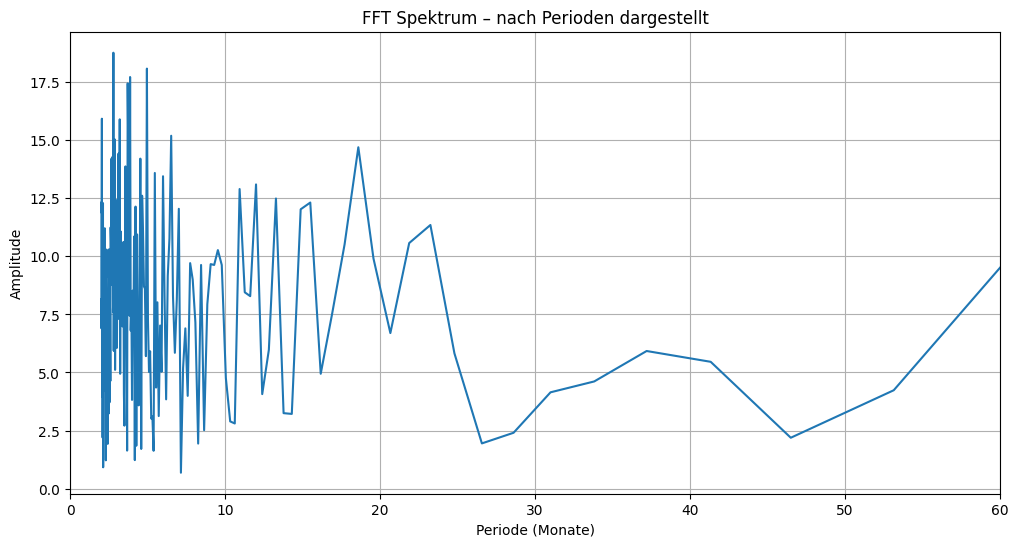

In [104]:
periods = 1 / xf

plt.figure(figsize=(12,6))
plt.plot(periods, amplitude)
plt.xlim(0, 60)  # Periode in Monaten (0–5 Jahre)
plt.xlabel("Periode (Monate)")
plt.ylabel("Amplitude")
plt.title("FFT Spektrum – nach Perioden dargestellt")
plt.grid(True)
plt.show()

Running MSTL with periods (2, 3, 4, 5, 6, 12) windows (51, 101, 101, 201, 201, 201)

Top 1: periods=[2, 3, 4, 5, 6, 12] windows=[51, 101, 101, 201, 201, 201] trend=301
  resid var = 6964.7857, ADF p = 0.0000


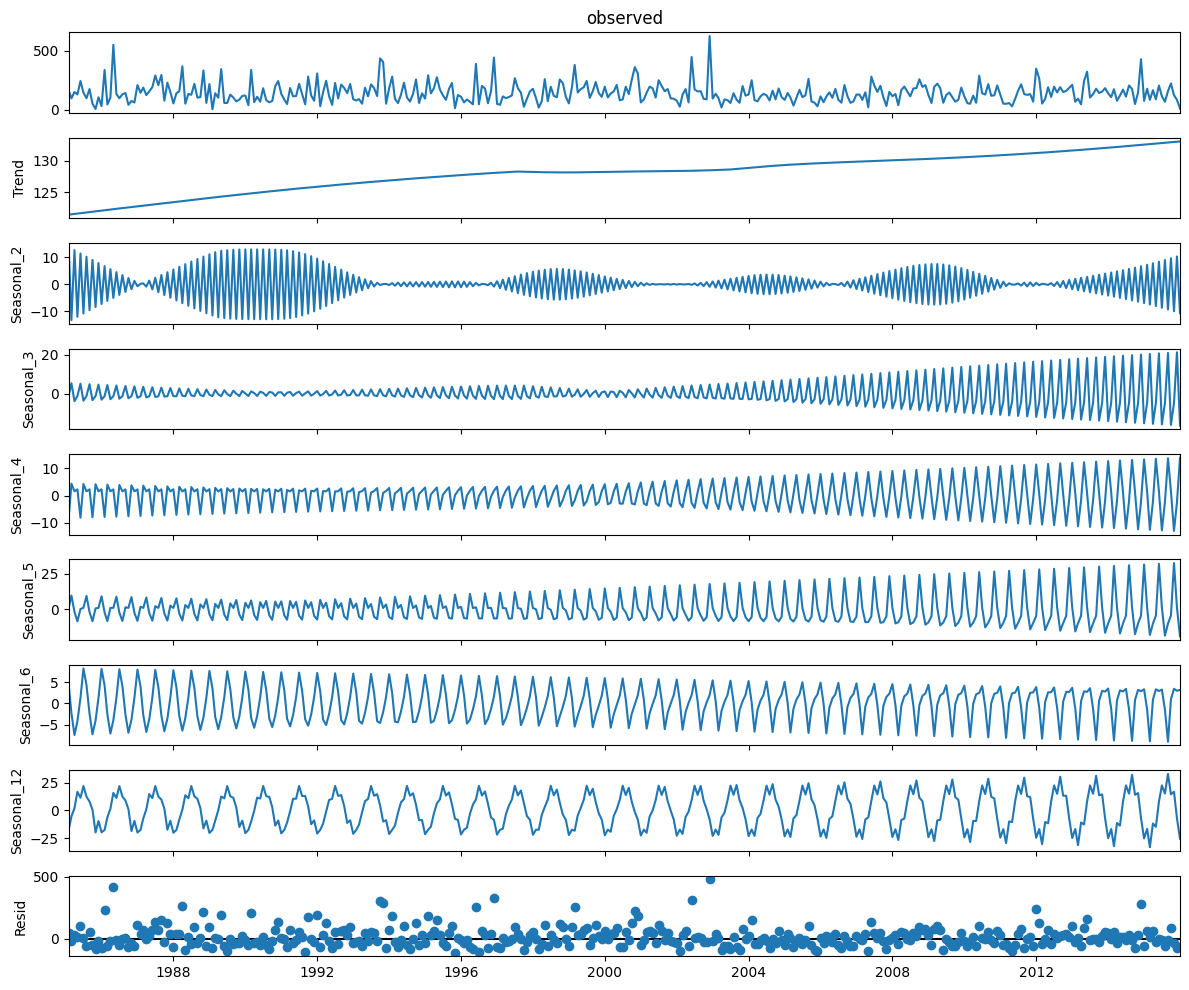

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller

# Daten vorbereiten
rain_m = rain_data.resample("ME").sum()
rain_m = rain_m["1985":"2015"]

def make_odd(x):
    x = int(x)
    return x if x % 2 == 1 else x + 1

def evaluate_mstl(series, periods, windows, robust=True):
    windows = [make_odd(w) for w in windows]
    trend = make_odd(int(1.5 * max(windows)))
    mstl = MSTL(series, periods=periods, windows=windows, lmbda=0,
                stl_kwargs={'trend':trend, 'robust':robust})
    res = mstl.fit()
    resid = res.resid.dropna()
    var_resid = resid.var()
    try:
        adf_p = adfuller(resid)[1]
    except:
        adf_p = np.nan
    return {'res': res, 'var_resid': var_resid, 'adf_p': adf_p,
            'periods': periods, 'windows': windows, 'trend': trend}

series = rain_m

candidate_periods = [
    (2,3,4,5,6,12)
]

candidate_windows = {
    (2,3,4,5,6,12): [(51,101,101,201,201,201)]
}

results = []
for periods in candidate_periods:
    for windows in candidate_windows[periods]:
        print("Running MSTL with periods", periods, "windows", windows)
        r = evaluate_mstl(series, periods=list(periods), windows=list(windows))
        results.append(r)

results_sorted = sorted(results, key=lambda x: (x['var_resid'], x['adf_p']))
        
for i, r in enumerate(results_sorted[:3], 1):
    print(f"\nTop {i}: periods={r['periods']} windows={r['windows']} trend={r['trend']}")
    print(f"  resid var = {r['var_resid']:.4f}, ADF p = {r['adf_p']:.4f}")

best = results_sorted[0]['res']
fig = best.plot()
fig.set_size_inches(12,10)
plt.tight_layout()
plt.show()
